# Przewidywanie zachowań zakupowych z wykorzystaniem metodologii uczenia maszynowego w Pythonie. 

### XGBoost

In [2]:
from random import shuffle
from random import randint
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from operator import itemgetter
import time
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

import gc

In [3]:
df_o = pd.read_csv("online_shoppers_intention.csv", sep = ',')
col_names = ['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']

for col in col_names:
    df_o[col] = df_o[col].astype('category',copy=False)
    
print(df_o.shape)
df_o.head()

(12330, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
target="Revenue"
numFeatures = ['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues','SpecialDay']
catFeatures = ['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']

In [5]:
# import narzędzia z biblioteki sklearn
from sklearn import preprocessing

# Kopiowanie obiektu
df = df_o.copy()
# Słownik zawierachąch mapy
mapy = {}
for feature in catFeatures:
    # Iniciujemy obiekt do kodowania, który będzie przechowywał mapę
    le = preprocessing.LabelEncoder()
    # Dopasowujemy kolumnę (tworzymy mapę) i od razu ją nakładamy na zmienną, na której robiliśmy dopasowanie
    df[feature] = le.fit_transform(df_o[feature])
    # Zapiszmy mapę, aby móc odzyskać informację o mapowaniu i oryginalnych wartościach
    mapy[feature] = le

In [6]:
features = df.columns.tolist()
features.remove(target)
print(features)

['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']


In [7]:
df[target] = (df[target]==True).astype(int)

### Wrapper dla XGBoost

In [8]:
def run_xgb(train, validate, features, target, # argumenty obowiązkowe
            eta=0.03, max_depth=7, subsample = 0.7, colsample_bytree = 0.7, # hiperparametry
            colsample_bylevel=1,lambdaX = 1, alpha=0, gamma=0, min_child_weight=0, # hiperparametry
            rate_drop = 0.2, skip_drop=0.5, # hiperparametry
            num_boost_round = 1000, early_stopping_rounds = 50, # hiperparametry
            debug=True, eval_metric= ["auc"], objective = "binary:logistic", # konfiguracja
            seed=2017, booster = "gbtree", tree_method="hist", grow_policy="depthwise",
           verbosity=1, silent=False): # konfiguracja
    '''
    Uniwersalny wrapper dla XGB dla gbtree i dart
    Więcej opcji https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    
    Parametry
    ----------
    train, validate, features, target : wymagane zmienne bez domyślnych wartości
    train, validate : pd.DataFrames z kolumnami opisanymi w features i target
    features : lista zmiennych do wykorzystania w trenowaniu
    target : nazwa zmiennej objasnianej
    
    --- Zmienne wspólne dla gbtree i dart
        --- Zmienne właściwe dla Ensamble/Boosting
        eta : "learning rate"
        max_depth=7 : maksymalna głębokość drzew [0,∞]
        subsample : udział (0,1] obserwacji do treningu jednej iteracji
        colsample_bytree : udział (0,1] kolumn do treningu jednej iteracji
        colsample_bylevel : udział  (0,1] kolumn na poziom do treningu jednej iteracji
        --- Zmienne regularyzacyjne
        lambdaX=0 : regularyzacja L2 [0,∞]
        alpha=0 : regularyzacja L1 [0,∞]
        gamma=1 : minimalna redukcja funkcji straty
        min_child_weight=0 : minimalna suma wg poddrzewa

    --- Zmienne dla algorytmu dart
    rate_drop : 
    skip_drop : 
    
    --- Zmienne dla XGB, opis/agorytm/liczba drzew etc.
    num_boost_round : maksymalna liczba iteracji
    early_stopping_rounds : margines iteracji dla early stopping
    debug : Czy włączyć pełne opisy.
    eval_metric : Pełna lista dostępna https://github.com/dmlc/xgboost/blob/master/doc/parameter.md 
    objective : reg:linear, reg:logistic, binary:logistic, multi:softmax lub inne Pełna lista dostępna https://github.com/dmlc/xgboost/blob/master/doc/parameter.md 
    seed : random seed
    booster : ‘auto’, ‘exact’, ‘approx’, ‘hist’, ‘gpu_exact’, ‘gpu_hist’- silnik dla drzew gbtree (cart), dart (gbtree z dropoutem) lub gblinear
    tree_method : zobacz http://xgboost.readthedocs.io/en/latest/parameter.html
    grow_policy : depthwise, lossguide
    '''
   
    start_time = time.time()
    paramList= ['eta', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel',
         'lambdaX', 'alpha', 'gamma', 'min_child_weight',
         'num_boost_round', 'early_stopping_rounds',
         'rate_drop', 'skip_drop',
         'eval_metric', 'objective', 
          'seed', 'booster', 'tree_method', 'grow_policy', 'verbosity', 'silent']
    
    # Stworzenie słownika do przekazania do XGB
    params = dict()
    for param in paramList:
        params[param]=eval(param)
    if(debug):
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length valid:', len(validate.index))

    # Automatyczne przekazanie liczby klas dla wielu poziomów klasyfikacji
    if (params["objective"]=="multi:softmax" or params["objective"]=="multi:softprob"):
        params["num_class"]=train[target].nunique()
    params["silent"]=1
    
    # XGB wymaga w słowniku parametrów słowa kluczowego lambda, poniżej workaround
    params["lambda"]=lambdaX
    
    # Przekształcenie zbiorów do struktury DMatrix
    # Struktura danych DMatrix pozwala na efektywne tworzenie drzew
    dtrain = xgb.DMatrix(train[features].values, train[target].values, feature_names=train[features].columns.values)
    dvalid = xgb.DMatrix(validate[features].values, validate[target].values, feature_names=validate[features].columns.values)

    # Stworzenie listy zbiorów do ealuacji
    evals = [(dtrain, 'train'), (dvalid, 'valid')]
    
    # Stworzenie zmiennej słownikowej do przekazania
    train_history = dict()

    # Uruchomienie algorytmu trenującego
    gbm = xgb.train(params, dtrain, 
                    num_boost_round, early_stopping_rounds=early_stopping_rounds,
                    evals=evals, evals_result=train_history, verbose_eval=debug)
    
    # Obliczenai statystyk i dodatkowych wartości
    score = gbm.best_score

    # Przekształcenie historii trenowania do Pandas Data Frame
    trainHistory = dict()
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    train_history = pd.DataFrame(trainHistory)

    # Zapis przewidywanych wartości dla zbioru walidacyjnego dla najlepszej (z punktu widzenia walidacji) iteracji
    trainPred = gbm.predict(dtrain, ntree_limit=gbm.best_iteration)
    testPred = gbm.predict(dvalid, ntree_limit=gbm.best_iteration)

    # Przygotowanie posortowanej listy dla wazności zmiennych, zamaist słownika
    imp = gbm.get_fscore()
    imp = sorted(imp.items(), key=itemgetter(1), reverse=True)

    impFig=None
    if(debug):
        print('Czas trenowania: {} minut'.format(round((time.time() - start_time)/60, 2)))
        # Skorzystanie z wbudowanej funkcji wizualizującej waznośc zmiennych
        impFig, ax = plt.subplots()
        xgb.plot_importance(gbm, ax=ax)
    return score, trainPred, testPred, train_history, impFig, imp

In [9]:
test_size = 0.3
X_train, X_valid = train_test_split(df, test_size=test_size, random_state=21, stratify=df[target].values)

Kiedy mamy już przygotowane zbiory do treningu i walidacji możemy przystąpić do pierwszego uruchomienia treningu XGB. Wszystkie parametry będą ustawione domyślnie z wyjątkiem early_stopping_rounds, który zwiększymy do 50, aby móc przyjrzeć się temu jak model się przetrenowuje.

eta 0.03, max_depth 7, subsample 0.7, colsample_bytree 0.7, colsample_bylevel 1, lambdaX 1, alpha 0, gamma 0, min_child_weight 0, num_boost_round 1000, early_stopping_rounds 50, rate_drop 0.2, skip_drop 0.5, eval_metric ['auc'], objective binary:logistic, seed 1104, booster gbtree, tree_method exact, grow_policy depthwise, verbosity 1, silent False, 
Length train: 8631
Length valid: 3699
[19:10:09] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.89274	valid-auc:0.87954
[1]	train-auc:0.91107	valid-auc:0.88639
[2]	train-auc:0.91203	valid-auc:0.87919
[3]	train-auc:0.93074	valid-auc:0.90644
[4]	train-auc:0.93852	valid-auc:0.91559
[5]	train-au

Czas trenowania: 0.06 minut


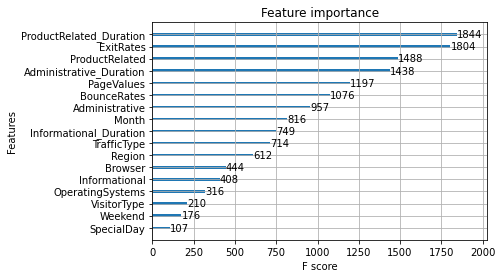

In [25]:
score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target, early_stopping_rounds=50)

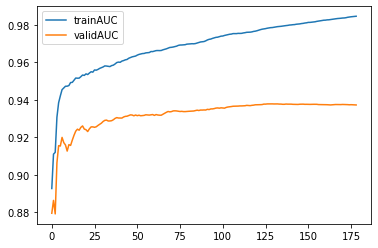

In [26]:
train_history.plot()
plt.show()

Jak widać algorytm bez problemu "przetrenowuje się" (overfitting). Ponieważ w XGBoost kolejne drzewa wykorzystują predykcje wcześniejszych modeli widzimy, że bardzo łatwe jest przetrenowanie modelu. Z tego powodu stosujemy tzw. early stopping, czyli zatrzymywanie treningu w sytuacji, w której wynik na zbiorze testowym zaczyna się pogarszać. Jest to bardzo prosta, ale również skuteczna metoda do określenia optymalnej liczby drzew w danym modelu.

## Dobór hiperparametrów

#### Glębokość drzew max depth

4 0.938173
6 0.937974
8 0.937431
10 0.93515
12 0.934016
14 0.93373


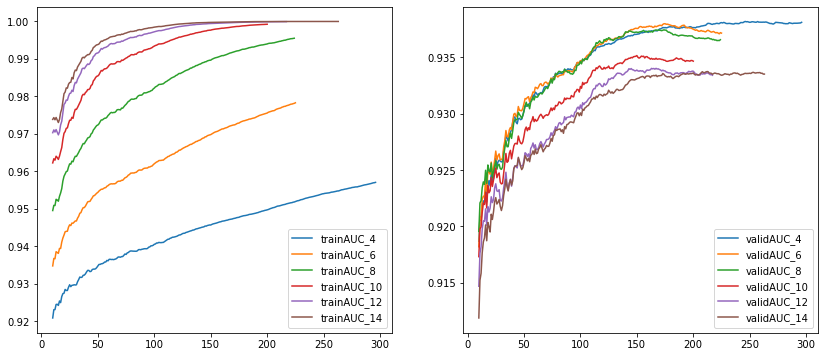

In [61]:
# Przygotowanie obiektu dla wyników
resHists = dict()
rang = range(4,15,2)
# Sprawdzenie modelu dla różnych wartości hiperparametru:
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=x, early_stopping_rounds=50, debug=False, verbosity=0)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Minimalnie najlepszy wynik dla 4, a dla tego poziomu nie widzimy przetrenowania.

### Udział wierszy i kolumn

0.3 0.937806
0.4 0.937656
0.5 0.93779
0.6 0.93811
0.7 0.938173
0.8 0.937669
0.9 0.937531


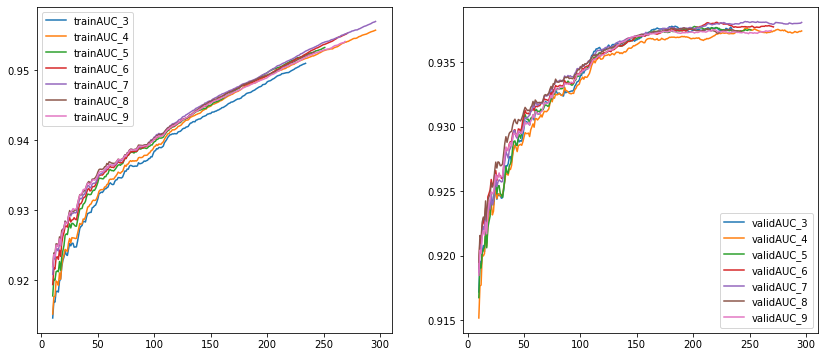

In [62]:
resHists = dict()
rang = range(3,10)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=4,  subsample=x/10,
                                                          early_stopping_rounds=50, debug=False, verbosity=0)
    resHists[x]=train_history
    print(x/10, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Wybieranie tylko części wierszy zdaje się nie wprowadzać dużych zmian. Nasz estymator jest bardzo stabilny pomiędzy różnymi wartościami hiperparametrów. 

0.3 0.9367
0.4 0.937481
0.5 0.938729
0.6 0.938209
0.7 0.938173
0.8 0.937683
0.9 0.938152


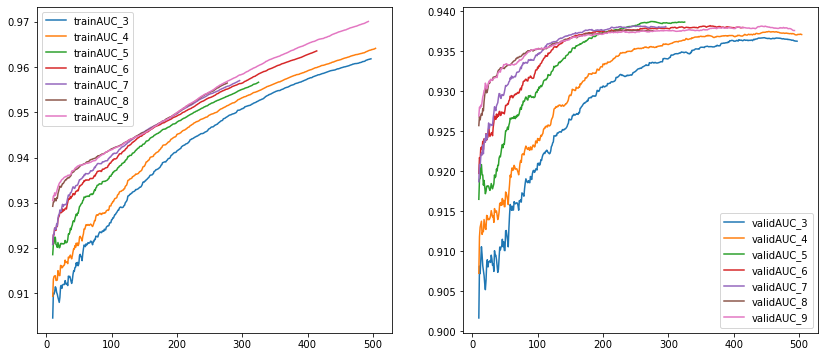

In [63]:
resHists = dict()
rang = range(3,10)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=4, subsample=0.7, colsample_bytree=x/10,
                                                          early_stopping_rounds=50, debug=False, verbosity=0)
    resHists[x]=train_history
    print(x/10, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

3 0.935537
4 0.936569
5 0.937738
6 0.937738
7 0.937926
8 0.937387
9 0.938066
10 0.938729


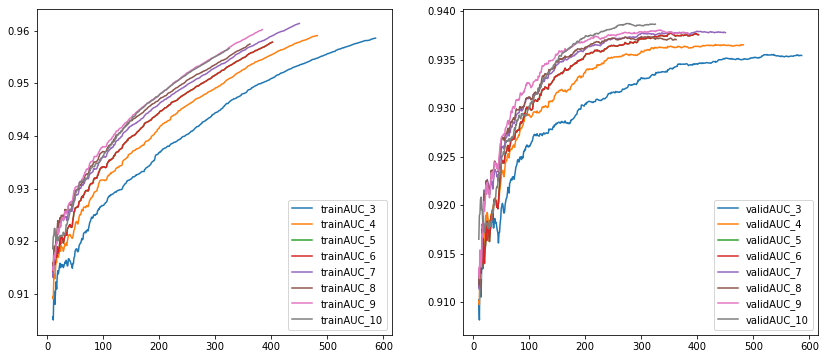

In [64]:
resHists = dict()
rang = range(3,11)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=4, subsample=0.7, colsample_bytree=0.5, colsample_bylevel=x/10,
                                                          early_stopping_rounds=50, debug=False, verbosity=0)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Z losowaniem wyłącznie per poziom:

3 0.937675
4 0.937249
5 0.937758
6 0.937204
7 0.937465
8 0.937132
9 0.936847
10 0.936736


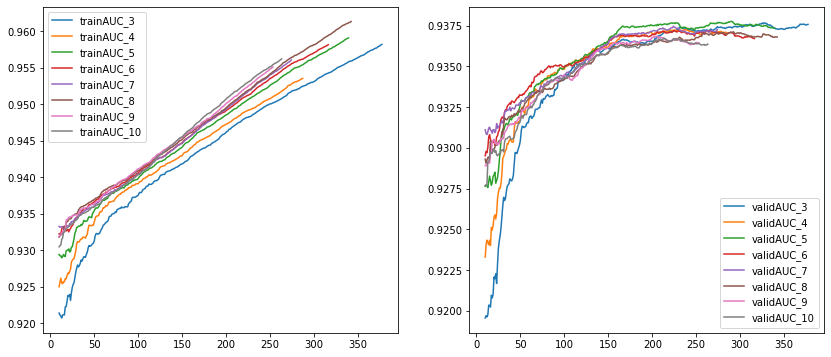

In [65]:
resHists = dict()
rang = range(3,11)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=4, subsample=0.7, colsample_bytree=1, colsample_bylevel=x/10,
                                                          early_stopping_rounds=50, debug=False, verbosity=0)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Lepsze wyniki niż z losowaniem by tree i potem by level. colsample_bylevel=1, by tree = 0.5

### Regularyzacja L2

0 0.938603
1 0.938729
4 0.938192
9 0.938382
16 0.938569
25 0.938406
36 0.937869
49 0.93816


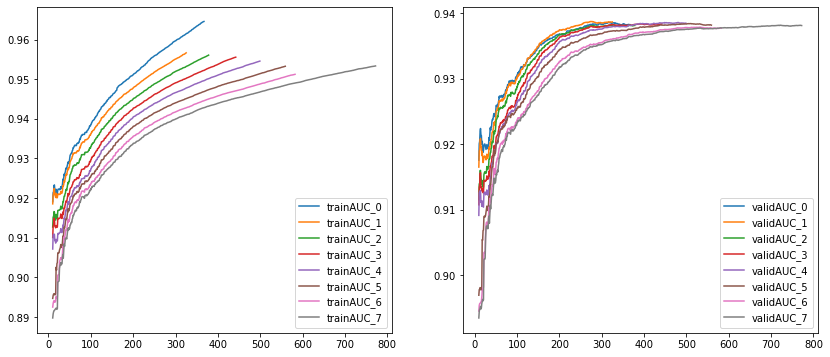

In [66]:
resHists = dict()

rang = range(0,8)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target, lambdaX=x**2,
                                                          max_depth=4, subsample=0.7, colsample_bytree=0.5, colsample_bylevel=1,
                                                          early_stopping_rounds=50, debug=False, verbosity=0)
    
    print(x**2, score)
    resHists[x]=train_history
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Minimalne różnie między poszczególnymi wartościami parametru "lambda". (Na poziomie tysięcznych)

### Parametr gamma - inny sposób na walkę z przetrenowaniem.

0 0.938729
0.01 0.938729
0.1 0.938709
0.5 0.93874
1 0.938616
2 0.938421
5 0.937254


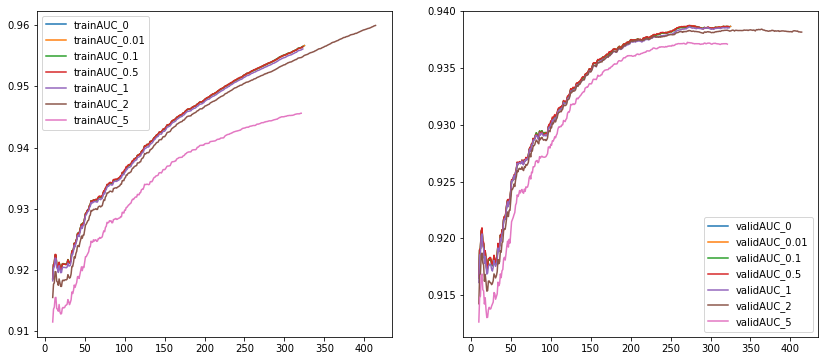

In [67]:
resHists = dict()

rang = [0, 0.01, 0.1, 0.5, 1, 2, 5]
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target, lambdaX=1,
                                                          max_depth=4, subsample=0.7, colsample_bytree=0.5,
                                                                     gamma=x, colsample_bylevel=1,
                                                          early_stopping_rounds=50, debug=False, verbosity=0)
    
    print(x, score)
    resHists[x]=train_history
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Znów otrzymujemy minimalne różnie między poszczególnymi wartościami parametru "gamma". Za optymalną uznajemy gamma = 0.5, wykorzystamy tę wartość do dalszej walidacji krzyżowej

### Walidacja krzyżowa xgboost

In [10]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


# Przygotujmy prosty wrapper
def CVTestXGB(nFolds = 5, randomState=21, features=features, debug=False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapisanie wyników ze zbioru treningowego i testowego
    testResults = []
    trainResults = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []
    
    # Przygotujmy listę historii
    hists = []
    fold = 1
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df.iloc[train], df.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(testPred.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df[target].iloc[train], trainPred)
        testScore = roc_auc_score(df[target].iloc[test], testPred)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices, pd.concat(hists, axis=1)

In [73]:
trainResults, testResults, predictions, indices, hists = CVTestXGB(
    max_depth=4, lambdaX=1, subsample=0.7, colsample_bytree=0.5, gamma=0.5, colsample_bylevel=1, debug=False, verbosity=0)
np.mean(trainResults), np.mean(testResults)

(0.9401997361700302, 0.925090018694703)

##### Znaczenie walidacji krzyżowej

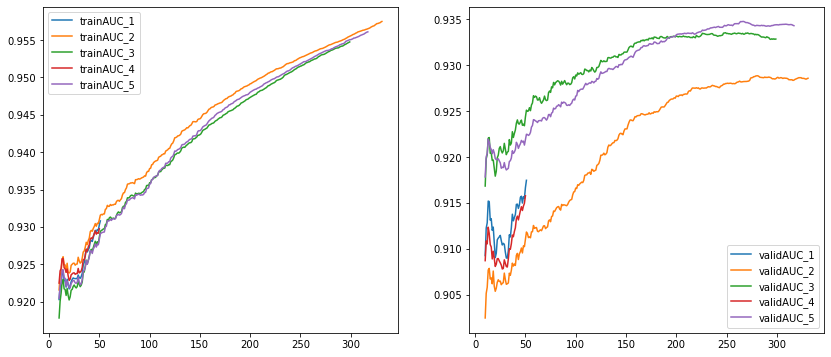

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
for x in range(1,6):
    hists[['trainAUC'+'_'+str(x)]].iloc[10:].plot(ax=ax[0])
    hists[['validAUC'+'_'+str(x)]].iloc[10:].plot(ax=ax[1])
plt.show()

### Dobór hiperparametrów z walidacją krzyżową

[17:59:23] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:59:26] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:59:29] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

[18:00:44] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:00:49] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:00:54] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

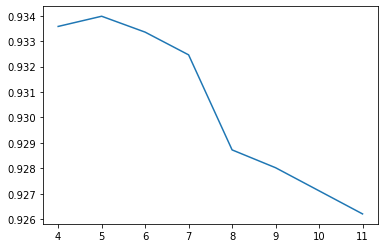

In [75]:
rang = range(4,12)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=x)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

Wyniki nie różnią się drastycznie (rozpiętość około 0,01). Wybieramy głębokość równą 5.

[18:03:13] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:03:16] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:03:19] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

[18:04:20] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:04:25] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:04:28] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

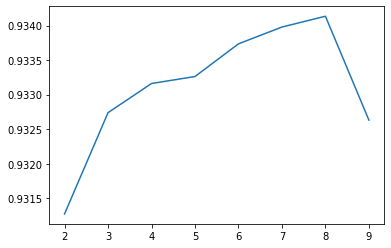

In [76]:
rang = range(2,10)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=5, subsample = x/10)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

Różnice na poziomie części tysięcznych, wybieramy subsample = 0.8

[18:06:42] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:06:43] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:06:44] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

[18:07:48] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:07:53] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:07:53] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

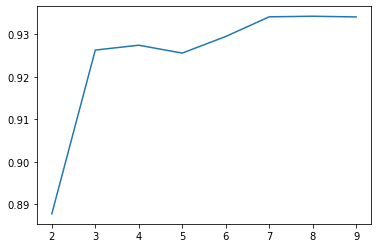

In [77]:
rang = range(2,10)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=5, subsample = 0.8, colsample_bytree = x/10)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

Minimalne różnice pomiędzy 7 a 9, wybieramy 7 unikając w miarę możliwośći skrajnych wartości.

[18:10:19] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:10:22] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:10:26] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

[18:11:42] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:11:46] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:11:50] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

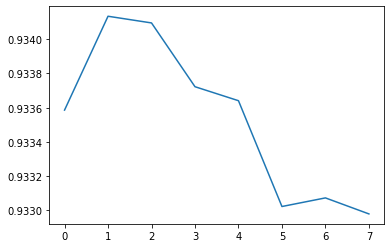

In [78]:
rang = range(0,8)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=5, subsample = 0.8, colsample_bytree = 0.7, lambdaX=x**2)
    print(x**2, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

Wybieramy lambda = 1

[18:14:30] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:33] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:37] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

[18:15:53] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:15:57] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:16:01] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

[18:17:23] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:17:27] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:17:31] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

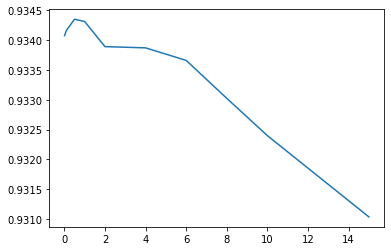

In [79]:
rang = [0.01, 0.1, 0.5, 1, 2, 4, 6, 8, 10, 15]
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=5, subsample = 0.8, colsample_bytree = 0.7, lambdaX=1, gamma=x)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

Gamma = 0.5

## Porównanie wyników

In [11]:
trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=5, subsample = 0.8, colsample_bytree = 0.7, lambdaX=1, gamma=0.5)
print(np.mean(testResults))

modelXGB = {
    "name":"XGB",
    "description":"Model XGB, ze zmiennymi kategorycznymi z LE",
    "specification":'max_depth=5, subsample = 0.8, colsample_bytree = 0.7, lambdaX=1, gamma=0.5',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

[19:57:07] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:57:10] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:57:15] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, lambdaX, num_boost_round, rate_drop, silent, skip_drop } might not be used.

  This may not be accurate due to some parameter

In [12]:
# Otwieramy plik do zapisu binarnego z wykorzystenim with
with open("model_XGB_1.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelXGB, fp)

In [13]:
len(predictions)

5

In [14]:
# Wczytajmy też wcześniej zapisane modele
with open("model_ekonometria_1.p", "rb") as fp:
    modelEkonometria = pickle.load(fp)
    
with open("model_svm_1.p", "rb") as fp:
    modelSVM = pickle.load(fp)
    
with open("model_kNN_1.p", "rb") as fp:
    modelkNN = pickle.load(fp)
    
with open("model_RF_1.p", "rb") as fp:
    modelRF = pickle.load(fp)

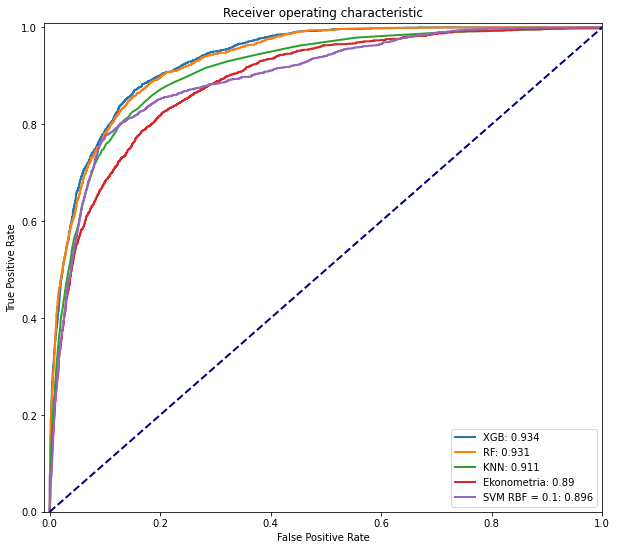

In [15]:
from helpers import plotROCs
res2plot = []
true = df[target].sort_index()
for result in [modelXGB, modelRF, modelkNN, modelEkonometria, modelSVM]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Wywołujemy funkcję do rysowania
plotROCs(res2plot)